In [7]:
%matplotlib inline

from matplotlib_inline import backend_inline
import numpy as np
import random
import math
import os
import scipy.io
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torch.nn.utils import weight_norm

from math import sqrt
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from IPython.display import display
from sklearn.metrics import r2_score

from pytorch_tcn.tcn import TCN

backend_inline.set_matplotlib_formats('svg')
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
plt.rcParams['font.sans-serif'] = ['SimHei']

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'mps')
# device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')


## 加载数据

In [8]:
# convert str to datatime
# 将字符串转换为时间
def convert_to_time(hmm):
    year, month, day, hour, minute, second = int(hmm[0]), int(hmm[1]), int(hmm[2]), int(hmm[3]), int(hmm[4]), int(hmm[5])
    return datetime(year=year, month=month, day=day, hour=hour, minute=minute, second=second)


# load .mat data
# 加载.mat格式的数据
def loadMat(matfile):
    data_mat = scipy.io.loadmat(matfile)
    filename = matfile.split("/")[-1].split(".")[0]
    col = data_mat[filename]
    col = col[0][0][0][0]
    size = col.shape[0]

    data_mat = []
    for i in range(size):
        k = list(col[i][3][0].dtype.fields.keys())
        d1, d2 = {}, {}
        if str(col[i][0][0]) != 'impedance':
            for j in range(len(k)):
                t = col[i][3][0][0][j][0];
                l = [t[m] for m in range(len(t))]
                d2[k[j]] = l
        d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(convert_to_time(col[i][2][0])), d2
        data_mat.append(d1)

    return data_mat

# get capacity data
# 得到电池容量的数据
def getBatteryCapacity(Battery):
    cycle, capacity = [], []
    i = 1
    for Bat in Battery:
        if Bat['type'] == 'discharge':
            capacity.append(Bat['data']['Capacity'][0])
            cycle.append(i)
            i += 1
    return [cycle, capacity]

Battery_list = ['B0005', 'B0006', 'B0007', 'B0018']
dir_path = './datasets/NASA/'

Battery = {}
for name in Battery_list:
    print('Load Dataset ' + name + '.mat ...')
    path = dir_path + name + '.mat'
    data_mat = loadMat(path)
    Battery[name] = getBatteryCapacity(data_mat)

Load Dataset B0005.mat ...


C:\Users\Coyle\AppData\Local\Temp\ipykernel_15284\3199085973.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(convert_to_time(col[i][2][0])), d2


Load Dataset B0006.mat ...
Load Dataset B0007.mat ...
Load Dataset B0018.mat ...


In [9]:
len(Battery['B0006'][0]), len(Battery['B0006'][1])

(168, 168)

## 画出数据

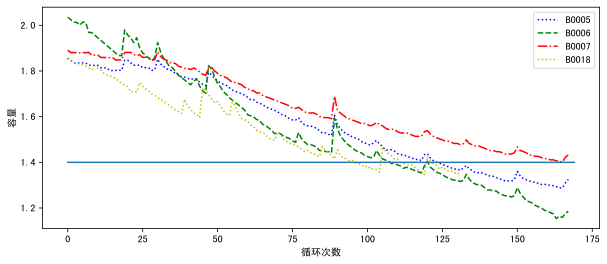

In [10]:
%matplotlib inline

def matplot_battery_list(battery_data_list):
    color_list = ['b:', 'g--', 'r-.', 'y:']
    # 1.创建画布
    plt.figure(figsize=(10, 4), dpi=80)
    plt.xlabel('循环次数')
    plt.ylabel('容量')

    # 2.绘制折线图
    for index, data in enumerate(battery_data_list):
        plt.plot([i for i in range(len(battery_data_list[index]))], battery_data_list[index], color_list[index])

    plt.plot([i for i in range(170)], [1.4] * 170)

    # 图例
    plt.legend([name for name in Battery_list])

Battery_data_list = [Battery['B0005'][1], Battery['B0006'][1], Battery['B0007'][1], Battery['B0018'][1]]
matplot_battery_list(Battery_data_list)

## 创建评估指标函数

In [11]:
# 平均绝对误差、均方根误差
def evaluation(y_test, y_predict):
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    r2 = r2_score(y_test, y_predict)
    return mae, rmse, r2

# 相对误差
# B0005 第125次循环后达到阈值1.4
# B0006 第109次循环后达到阈值1.4
# B0007 数据集中无任何值小于1.4，所以无法达到阈值1.4
# B0018 第97次循环后达到阈值1.4
def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), len(y_predict)
    for i in range(len(y_test) - 1):
        if y_test[i] <= threshold >= y_test[i + 1]:
            true_re = i + 1
            break
    for i in range(len(y_predict) - 1):
        if y_predict[i] <= threshold >= y_predict[i + 1]:
            pred_re = i + 1
            break
    return abs(true_re - pred_re) / true_re

# relative_error(Battery['B0006'][1], Battery['B0006'][1], 1.4)

## 构建训练序列数据

In [13]:
# 构建数据
# 采用 留一评估：一组数据为测试集，其他所有数据全部拿来训练
# train_x 的维度是 window_size ，总样本数为 421
# train_y 的维度是1，总样本数为421
# train_data 是模型预测时的真实数据，用来预测下一时刻的容量，长度为 window_size
# test_data 是 真实的容量数据，用来检验模型的各种参数

def build_seq(text, window_size):
    # text:list of capacity
    x, y = [], []
    for i in range(len(text) - window_size):
        sequence = text[i:i + window_size]
        target = text[i + 1:i + window_size + 1]
        x.append(sequence)
        y.append(target)

    return np.array(x), np.array(y)

def get_train_test_data(data_list, battery_i, window_size=16):
    data_sequence = Battery[Battery_list[battery_i]][1]
    train_data, test_data = data_sequence[:window_size], data_sequence[window_size:]
    
    train_x, train_y = None, None
    for i, v in enumerate(data_list):
        if i != battery_i:
            data_x, data_y = build_seq(text=v, window_size=window_size)
            if train_x is None:
                train_x = data_x
                train_y = data_y
            else:
                train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]

    return train_x, train_y, list(train_data), list(test_data)

def load_capacity_data(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

## 检验 train_iter 数据是否正确

In [14]:
train_x, train_y, train_data, test_data = get_train_test_data(Battery_data_list, 0, window_size=16)
train_x = torch.from_numpy(train_x.astype(np.float32))
train_y = torch.from_numpy(train_y.astype(np.float32))
train_iter = load_capacity_data((train_x, train_y), 2, is_train=False)

# 测试 train_iter 的数据是否正确
def validate_train_iter(train_iter):
    for x, y in train_iter:
        print(x.shape)
        print(y.shape)
        
        print(x)
        print(y)
        break



validate_train_iter(train_iter)

torch.Size([2, 16])
torch.Size([2, 16])
tensor([[2.0353, 2.0251, 2.0133, 2.0133, 2.0005, 2.0139, 2.0131, 1.9688, 1.9682,
         1.9572, 1.9456, 1.9348, 1.9233, 1.9119, 1.9011, 1.8892],
        [2.0251, 2.0133, 2.0133, 2.0005, 2.0139, 2.0131, 1.9688, 1.9682, 1.9572,
         1.9456, 1.9348, 1.9233, 1.9119, 1.9011, 1.8892, 1.8783]])
tensor([[2.0251, 2.0133, 2.0133, 2.0005, 2.0139, 2.0131, 1.9688, 1.9682, 1.9572,
         1.9456, 1.9348, 1.9233, 1.9119, 1.9011, 1.8892, 1.8783],
        [2.0133, 2.0133, 2.0005, 2.0139, 2.0131, 1.9688, 1.9682, 1.9572, 1.9456,
         1.9348, 1.9233, 1.9119, 1.9011, 1.8892, 1.8783, 1.8676]])


## 绘制 out 和  tgt_y的对比图

In [15]:
# 绘制 out  tgt_y的对比图
def matlab_make(out, tgt_y):
    color_list = ['b:', 'g:']
    # 1.创建画布
    fig = plt.figure(figsize=(7, 2), dpi=80)
    plt.xlabel('循环次数')
    plt.ylabel('容量')
    
    data_list = [
        {
            'name': 'out',
            'x': [i for i in range(len(out))],
            'y': out
        },
        {
            'name': 'tgt_y',
            'x': [i for i in range(len(tgt_y))],
            'y': tgt_y
        }
    ]

    # 2.绘制折线图
    for data,color in zip(data_list, color_list):
        plt.plot(data['x'], data['y'], color)


    # 图例
    plt.legend([data['name'] for data in data_list])
    
    display(fig)
    plt.close() 

# out_t = [1,2,3,4,5,6,7,8,9,10]
# tgt_y_t = [11,21,31,41,51,61,71,81,91,110]

# matlab_make(out_t, tgt_y_t)

## 随机种子

In [16]:
# 设置随机种子
def setup_seed(seed):
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed)  # 为了禁止hash随机化，使得实验可复现。
    torch.manual_seed(seed)  # 为CPU设置随机种子
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)  # 为当前GPU设置随机种子
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU，为所有GPU设置随机种子
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

## TCN 模型 源自论文源码

In [18]:
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

## TCN模型 源自pytorch-tcn

In [ ]:
TCN(num_inputs)

## 搭建模型

In [21]:
class Net(nn.Module):

    def __init__(self, input_size, num_channels, kernel_size, dropout):
        super(Net, self).__init__()

        # self.tcn = TemporalConvNet(input_size, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.tcn = TCN(input_size, num_channels, kernel_size=kernel_size, dropout=dropout)
        
        self.linear = nn.Linear(num_channels[-1], 1)
        
        self.init_weights()
        
    def init_weights(self):
        self.linear.weight.data.normal_(0, 0.01)

    def forward(self, x):
        x = x.reshape(x.shape[0], 1, x.shape[1])
        # print('x.shape', x.shape)
        y1 = self.tcn(x)
        # print('y1.shape', y1.shape)
        # print('y1[:, :, -1].shape', y1[:, :, -1].shape)
        return self.linear(y1[:, :, -1])

        

## 测试模型的输出形状

In [22]:
# 测试模型的输出形状
net = Net(1, [30, 30, 30, 30, 30, 30, 30, 30], 3, 0.0).to(device)

# src = torch.LongTensor([[0, 3, 4, 5, 6, 1, 2, 2]])
x = torch.ones((32, 16), dtype=torch.float32).to(device)

out = net(x)
print(out.size())

torch.Size([32, 1])


## 一个批次的训练函数

In [23]:
def train_epoch(net, train_iter, loss, updater): 
    # 将模型设置为训练模式
    net.train()
    
    # 训练损失总和、训练准确度总和、样本数
    for x, y in train_iter:
        # 计算梯度并更新参数
        x = torch.reshape(x, (-1, x.shape[-1])).type(torch.float32)
        
        y = y[:, -1:].type(torch.float32)
        
        x, y = x.to(device), y.to(device)
        #print(src.device)
        #print(tgt.device)
        
        updater.zero_grad()
        
        out = net(x)
        # print('out.shape is', out.shape)
        # print('y.shape is', y.shape)
        
    
        #print('111out', out.shape) # (50, 153, 1)
        # print('111tgt_y', tgt_y.shape) # (50, 153)
        
        l = loss(out.reshape(-1), y.reshape(-1))
        
        #print('222out', out[-1, :, :].cpu().data.numpy().shape) # (50, 153, 1)
        #print('222tgt_y', tgt_y.shape) # (50, 153)
        
        
        l.backward()
        
        updater.step()
    
    return l

## 总的训练函数

In [24]:
def train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity, i, seed):
    net = net.to(device)
    
    mae_epoch_list, rmse_epoch_list, re_epoch_list, r2_epoch_list = [], [], [], []
    for epoch in range(num_epochs):
        train_loss = train_epoch(net, train_iter, loss, updater)
        
        # if (epoch + 1) % 100 == 0:
        pre_list = predict(net, train_data, test_data, Rated_Capacity)
        
        test_y = test_data.copy()

        mae, rmse, r2 = evaluation(test_data, pre_list)
        re = relative_error(test_y, pre_list, threshold=Rated_Capacity * 0.7)

        # if (len(re_epoch_list) == 0 or (r2_epoch_list[-1] < r2)):
        print('seed: {}, 测试集: {}, epoch:{:<4d} , loss:{:<6.10f} , MAE:{:<6.4f} , RMSE:{:<6.4f} , RE:{:<6.4f} , R2:{:<6.4f}'.format(seed, Battery_list[i], epoch + 1, train_loss, mae, rmse, re, r2))
        mae_epoch_list.append(mae)
        rmse_epoch_list.append(rmse)
        re_epoch_list.append(re)
        r2_epoch_list.append(r2)


        # matlab_make(pre_list, test_y)

        # if (train_loss < 1e-3) and len(re_epoch_list) > 0 and 0.0 < re_epoch_list[-1] < 0.2 and (re_epoch_list[-1] < re):
        #     break

    return mae_epoch_list[-1], rmse_epoch_list[-1], re_epoch_list[-1], r2_epoch_list[-1]

## 预测函数

In [27]:
def predict(net, train_data, test_data, Rated_Capacity):
    # print()
    net = net.eval()
    
    x = train_data.copy()
    x = np.array(x)
    x = torch.from_numpy(x).type(torch.float32).to(device)
    x = torch.reshape(x, (1, -1)) # shape: (batch_size, input_size)
    # print('x.shape', x.shape)
    
    pre_list = []
    while len(pre_list) < len(test_data):
        
        # print(x)
        out = net(x)
        # print(out)
        # print()
        # print('out.shape', out.shape)
        # print('x[:, 1:].shape', x[:, 1:].shape)
        # print('out[:, -1:].shape', out[:, -1:].shape)
        x = torch.cat([x[:, 1:], out[:, -1:]], dim=1)
        
        pred = out.reshape(-1)
        
        pred_next_point = pred.cpu().data.numpy()[-1]
        
        
        pre_list.append(pred_next_point)
        
    # print(pre_list) 
    return pre_list
        
    
# x = train_data.copy()
# pred_list = predict(net, train_data, test_data, 2)
# print((pred_list))
# print((test_data))

# print(len(pred_list))
# print(len(test_data))
# matlab_make(pred_list, test_data)

## 开始训练 num_epochs = 500

### is_train=True 判断函数是(r2_epoch_list[-1] < r2)

In [30]:
# 电池额定容量
Rated_Capacity = 2.0

# 超参数
batch_size = 32
lr = 0.0001
weight_decay = 0.0005
num_epochs = 200
# num_epochs = 1
window_size = 16
kernel_size = 2
dropout = 0.0

# 获取数据集，生成train_iter
# 使用留一评估
re_seed_all, mae_seed_all, rmse_seed_all, r2_seed_all = [], [], [], []
for seed in range(2, 10):
    print('*******************************************************************************************************************')
    print('当前的 seed 为', seed)
    setup_seed(seed)
    mae_s, rmse_s, re_s, r2_s = [], [], [], []
    for i in range(4):
    # for i in range(1):
        train_x, train_y, train_data, test_data = get_train_test_data(Battery_data_list, i, window_size=window_size)
        train_x = torch.from_numpy(train_x.astype(np.float32))
        train_y = torch.from_numpy(train_y.astype(np.float32))
        train_iter = load_capacity_data((train_x, train_y), batch_size, is_train=True)

        # 模型、损失函数、优化器
        net = Net(1, [16] * 2, kernel_size, dropout)
        loss = nn.MSELoss()
        updater = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

        # 开始训练
        print(f'以电池 { Battery_list[i] } 为测试数据的 数据集 开始训练')
        #train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity)
        mae, rmse, re, r2 = train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity, i, seed)
        mae_s.append(mae)
        rmse_s.append(rmse)
        re_s.append(re)
        r2_s.append(r2)

    print('---------------------------------')
    print('re_s', re_s)
    print('---------------------------------')
    print(f're mean: {np.array(re_s).mean()}')
    print(f'mae mean: {np.array(mae_s).mean()}')
    print(f'rmse mean: {np.array(rmse_s).mean()}')
    print(f'r2 mean: {np.array(r2_s).mean()}')
    print('---------------------------------')

    re_seed_all.append(np.array(re_s).mean())
    mae_seed_all.append(np.array(mae_s).mean())
    rmse_seed_all.append(np.array(rmse_s).mean())
    r2_seed_all.append(np.array(r2_s).mean())

print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
print('------------   平均值   ---------------------')
print(f're mean: {np.array(re_seed_all).mean()}')
print(f'mae mean: {np.array(mae_seed_all).mean()}')
print(f'rmse mean: {np.array(rmse_seed_all).mean()}')
print(f'r2 mean: {np.array(r2_seed_all).mean()}')
print('---------------------------------------------')

print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
print('------------   最小值   ---------------------')
print(f're min: {np.array(re_seed_all).min()}')
print(f'mae min: {np.array(mae_seed_all).min()}')
print(f'rmse min: {np.array(rmse_seed_all).min()}')
print(f'r2 min: {np.array(r2_seed_all).max()}')
print('---------------------------------------------')

*******************************************************************************************************************
当前的 seed 为 2
以电池 B0005 为测试数据的 数据集 开始训练
seed: 2, 测试集: B0005, epoch:1    , loss:1.8629014492 , MAE:1.3993 , RMSE:1.4108 , RE:0.9908 , R2:-60.6113
seed: 2, 测试集: B0005, epoch:2    , loss:1.9785821438 , MAE:1.3867 , RMSE:1.3982 , RE:0.9908 , R2:-59.5206
seed: 2, 测试集: B0005, epoch:3    , loss:1.7256989479 , MAE:1.3740 , RMSE:1.3856 , RE:0.9908 , R2:-58.4329
seed: 2, 测试集: B0005, epoch:4    , loss:1.3473974466 , MAE:1.3610 , RMSE:1.3727 , RE:0.9908 , R2:-57.3329
seed: 2, 测试集: B0005, epoch:5    , loss:1.6778869629 , MAE:1.3475 , RMSE:1.3594 , RE:0.9908 , R2:-56.2028
seed: 2, 测试集: B0005, epoch:6    , loss:1.9621496201 , MAE:1.3332 , RMSE:1.3452 , RE:0.9908 , R2:-55.0128
seed: 2, 测试集: B0005, epoch:7    , loss:1.6787403822 , MAE:1.3177 , RMSE:1.3298 , RE:0.9908 , R2:-53.7395
seed: 2, 测试集: B0005, epoch:8    , loss:1.7783172131 , MAE:1.3005 , RMSE:1.3128 , RE:0.9908 , R2:-52.3463
seed:

seed: 2, 测试集: B0005, epoch:79   , loss:0.0095697939 , MAE:0.1546 , RMSE:0.1740 , RE:0.3945 , R2:0.0627
seed: 2, 测试集: B0005, epoch:80   , loss:0.0090239011 , MAE:0.1545 , RMSE:0.1739 , RE:0.3945 , R2:0.0640
seed: 2, 测试集: B0005, epoch:81   , loss:0.0066703223 , MAE:0.1546 , RMSE:0.1740 , RE:0.3945 , R2:0.0627
seed: 2, 测试集: B0005, epoch:82   , loss:0.0069185137 , MAE:0.1547 , RMSE:0.1741 , RE:0.3945 , R2:0.0622
seed: 2, 测试集: B0005, epoch:83   , loss:0.0038287989 , MAE:0.1551 , RMSE:0.1744 , RE:0.3945 , R2:0.0581
seed: 2, 测试集: B0005, epoch:84   , loss:0.0054307496 , MAE:0.1548 , RMSE:0.1741 , RE:0.3945 , R2:0.0613
seed: 2, 测试集: B0005, epoch:85   , loss:0.0047617094 , MAE:0.1539 , RMSE:0.1734 , RE:0.3945 , R2:0.0691
seed: 2, 测试集: B0005, epoch:86   , loss:0.0093401056 , MAE:0.1540 , RMSE:0.1735 , RE:0.3945 , R2:0.0686
seed: 2, 测试集: B0005, epoch:87   , loss:0.0051540793 , MAE:0.1546 , RMSE:0.1739 , RE:0.3945 , R2:0.0634
seed: 2, 测试集: B0005, epoch:88   , loss:0.0032599282 , MAE:0.1548 , RMSE:0

seed: 2, 测试集: B0005, epoch:159  , loss:0.0006535046 , MAE:0.1451 , RMSE:0.1632 , RE:0.3945 , R2:0.1752
seed: 2, 测试集: B0005, epoch:160  , loss:0.0035239821 , MAE:0.1445 , RMSE:0.1627 , RE:0.3945 , R2:0.1802
seed: 2, 测试集: B0005, epoch:161  , loss:0.0021648502 , MAE:0.1444 , RMSE:0.1625 , RE:0.3945 , R2:0.1823
seed: 2, 测试集: B0005, epoch:162  , loss:0.0038713771 , MAE:0.1435 , RMSE:0.1619 , RE:0.3945 , R2:0.1883
seed: 2, 测试集: B0005, epoch:163  , loss:0.0023795320 , MAE:0.1440 , RMSE:0.1620 , RE:0.3945 , R2:0.1873
seed: 2, 测试集: B0005, epoch:164  , loss:0.0010959913 , MAE:0.1426 , RMSE:0.1613 , RE:0.3945 , R2:0.1943
seed: 2, 测试集: B0005, epoch:165  , loss:0.0008619931 , MAE:0.1443 , RMSE:0.1621 , RE:0.3945 , R2:0.1866
seed: 2, 测试集: B0005, epoch:166  , loss:0.0006628426 , MAE:0.1424 , RMSE:0.1607 , RE:0.3945 , R2:0.2010
seed: 2, 测试集: B0005, epoch:167  , loss:0.0016768090 , MAE:0.1418 , RMSE:0.1605 , RE:0.3945 , R2:0.2022
seed: 2, 测试集: B0005, epoch:168  , loss:0.0008179107 , MAE:0.1438 , RMSE:0

seed: 2, 测试集: B0006, epoch:38   , loss:0.0047861193 , MAE:0.1902 , RMSE:0.2164 , RE:0.6344 , R2:0.0397
seed: 2, 测试集: B0006, epoch:39   , loss:0.0064198612 , MAE:0.1892 , RMSE:0.2154 , RE:0.6344 , R2:0.0484
seed: 2, 测试集: B0006, epoch:40   , loss:0.0065839523 , MAE:0.1901 , RMSE:0.2163 , RE:0.6344 , R2:0.0403
seed: 2, 测试集: B0006, epoch:41   , loss:0.0060791317 , MAE:0.1914 , RMSE:0.2177 , RE:0.6344 , R2:0.0285
seed: 2, 测试集: B0006, epoch:42   , loss:0.0051659653 , MAE:0.1919 , RMSE:0.2181 , RE:0.6344 , R2:0.0248
seed: 2, 测试集: B0006, epoch:43   , loss:0.0050386256 , MAE:0.1897 , RMSE:0.2159 , RE:0.6344 , R2:0.0440
seed: 2, 测试集: B0006, epoch:44   , loss:0.0021292744 , MAE:0.1900 , RMSE:0.2163 , RE:0.6344 , R2:0.0408
seed: 2, 测试集: B0006, epoch:45   , loss:0.0064258147 , MAE:0.1910 , RMSE:0.2172 , RE:0.6344 , R2:0.0322
seed: 2, 测试集: B0006, epoch:46   , loss:0.0044035469 , MAE:0.1923 , RMSE:0.2185 , RE:0.6344 , R2:0.0208
seed: 2, 测试集: B0006, epoch:47   , loss:0.0033212502 , MAE:0.1927 , RMSE:0

seed: 2, 测试集: B0006, epoch:118  , loss:0.0008519098 , MAE:0.1791 , RMSE:0.2051 , RE:0.6344 , R2:0.1373
seed: 2, 测试集: B0006, epoch:119  , loss:0.0034241290 , MAE:0.1772 , RMSE:0.2032 , RE:0.6344 , R2:0.1536
seed: 2, 测试集: B0006, epoch:120  , loss:0.0020508119 , MAE:0.1754 , RMSE:0.2012 , RE:0.6344 , R2:0.1699
seed: 2, 测试集: B0006, epoch:121  , loss:0.0017795360 , MAE:0.1758 , RMSE:0.2017 , RE:0.6344 , R2:0.1657
seed: 2, 测试集: B0006, epoch:122  , loss:0.0033637723 , MAE:0.1754 , RMSE:0.2013 , RE:0.6344 , R2:0.1689
seed: 2, 测试集: B0006, epoch:123  , loss:0.0013792523 , MAE:0.1805 , RMSE:0.2071 , RE:0.6344 , R2:0.1208
seed: 2, 测试集: B0006, epoch:124  , loss:0.0015403880 , MAE:0.1723 , RMSE:0.1980 , RE:0.6344 , R2:0.1960
seed: 2, 测试集: B0006, epoch:125  , loss:0.0023327540 , MAE:0.1702 , RMSE:0.1958 , RE:0.6344 , R2:0.2136
seed: 2, 测试集: B0006, epoch:126  , loss:0.0029042920 , MAE:0.1736 , RMSE:0.1996 , RE:0.6344 , R2:0.1834
seed: 2, 测试集: B0006, epoch:127  , loss:0.0010246158 , MAE:0.1731 , RMSE:0

seed: 2, 测试集: B0006, epoch:198  , loss:0.0004312881 , MAE:0.0888 , RMSE:0.1092 , RE:0.6344 , R2:0.7554
seed: 2, 测试集: B0006, epoch:199  , loss:0.0000296160 , MAE:0.1217 , RMSE:0.1461 , RE:0.6344 , R2:0.5625
seed: 2, 测试集: B0006, epoch:200  , loss:0.0000703014 , MAE:0.1018 , RMSE:0.1230 , RE:0.6344 , R2:0.6900
以电池 B0007 为测试数据的 数据集 开始训练
seed: 2, 测试集: B0007, epoch:1    , loss:2.8886189461 , MAE:1.8311 , RMSE:1.8372 , RE:0.9934 , R2:-149.6960
seed: 2, 测试集: B0007, epoch:2    , loss:2.8537638187 , MAE:1.8227 , RMSE:1.8288 , RE:0.9934 , R2:-148.3222
seed: 2, 测试集: B0007, epoch:3    , loss:2.4662842751 , MAE:1.8135 , RMSE:1.8196 , RE:0.9934 , R2:-146.8341
seed: 2, 测试集: B0007, epoch:4    , loss:3.0973885059 , MAE:1.8036 , RMSE:1.8097 , RE:0.9934 , R2:-145.2334
seed: 2, 测试集: B0007, epoch:5    , loss:2.2855286598 , MAE:1.7931 , RMSE:1.7992 , RE:0.9934 , R2:-143.5367
seed: 2, 测试集: B0007, epoch:6    , loss:2.3010914326 , MAE:1.7820 , RMSE:1.7882 , RE:0.9934 , R2:-141.7689
seed: 2, 测试集: B0007, epoch:7 

seed: 2, 测试集: B0007, epoch:77   , loss:0.0002306029 , MAE:0.1281 , RMSE:0.1453 , RE:0.0000 , R2:0.0570
seed: 2, 测试集: B0007, epoch:78   , loss:0.0015389491 , MAE:0.1176 , RMSE:0.1359 , RE:0.0000 , R2:0.1753
seed: 2, 测试集: B0007, epoch:79   , loss:0.0004910097 , MAE:0.1112 , RMSE:0.1299 , RE:0.0000 , R2:0.2471
seed: 2, 测试集: B0007, epoch:80   , loss:0.0014926055 , MAE:0.1193 , RMSE:0.1370 , RE:0.0000 , R2:0.1623
seed: 2, 测试集: B0007, epoch:81   , loss:0.0003222115 , MAE:0.1085 , RMSE:0.1270 , RE:0.0000 , R2:0.2793
seed: 2, 测试集: B0007, epoch:82   , loss:0.0010247353 , MAE:0.1275 , RMSE:0.1436 , RE:0.0132 , R2:0.0789
seed: 2, 测试集: B0007, epoch:83   , loss:0.0049250741 , MAE:0.1176 , RMSE:0.1349 , RE:0.0000 , R2:0.1877
seed: 2, 测试集: B0007, epoch:84   , loss:0.0004199821 , MAE:0.1080 , RMSE:0.1260 , RE:0.0000 , R2:0.2912
seed: 2, 测试集: B0007, epoch:85   , loss:0.0009750552 , MAE:0.1193 , RMSE:0.1359 , RE:0.0000 , R2:0.1749
seed: 2, 测试集: B0007, epoch:86   , loss:0.0000874624 , MAE:0.1294 , RMSE:0

seed: 2, 测试集: B0007, epoch:157  , loss:0.0005897949 , MAE:0.1468 , RMSE:0.1507 , RE:0.4211 , R2:-0.0137
seed: 2, 测试集: B0007, epoch:158  , loss:0.0034667233 , MAE:0.1131 , RMSE:0.1181 , RE:0.2829 , R2:0.3773
seed: 2, 测试集: B0007, epoch:159  , loss:0.0001789146 , MAE:0.1114 , RMSE:0.1164 , RE:0.2763 , R2:0.3949
seed: 2, 测试集: B0007, epoch:160  , loss:0.0001173135 , MAE:0.1300 , RMSE:0.1341 , RE:0.3618 , R2:0.1977
seed: 2, 测试集: B0007, epoch:161  , loss:0.0000999081 , MAE:0.1362 , RMSE:0.1400 , RE:0.3882 , R2:0.1243
seed: 2, 测试集: B0007, epoch:162  , loss:0.0002470574 , MAE:0.1258 , RMSE:0.1299 , RE:0.3487 , R2:0.2466
seed: 2, 测试集: B0007, epoch:163  , loss:0.0000894404 , MAE:0.1262 , RMSE:0.1302 , RE:0.3487 , R2:0.2433
seed: 2, 测试集: B0007, epoch:164  , loss:0.0002082249 , MAE:0.1312 , RMSE:0.1350 , RE:0.3684 , R2:0.1859
seed: 2, 测试集: B0007, epoch:165  , loss:0.0004050136 , MAE:0.1136 , RMSE:0.1180 , RE:0.2961 , R2:0.3786
seed: 2, 测试集: B0007, epoch:166  , loss:0.0005265257 , MAE:0.1241 , RMSE:

seed: 2, 测试集: B0018, epoch:36   , loss:0.0053540999 , MAE:0.1079 , RMSE:0.1187 , RE:0.4321 , R2:0.1530
seed: 2, 测试集: B0018, epoch:37   , loss:0.0071912850 , MAE:0.1086 , RMSE:0.1198 , RE:0.4321 , R2:0.1369
seed: 2, 测试集: B0018, epoch:38   , loss:0.0144607443 , MAE:0.1077 , RMSE:0.1186 , RE:0.4321 , R2:0.1551
seed: 2, 测试集: B0018, epoch:39   , loss:0.0019999049 , MAE:0.1085 , RMSE:0.1197 , RE:0.4321 , R2:0.1391
seed: 2, 测试集: B0018, epoch:40   , loss:0.0032069702 , MAE:0.1079 , RMSE:0.1188 , RE:0.4321 , R2:0.1515
seed: 2, 测试集: B0018, epoch:41   , loss:0.0029848237 , MAE:0.1074 , RMSE:0.1183 , RE:0.4321 , R2:0.1597
seed: 2, 测试集: B0018, epoch:42   , loss:0.0031421199 , MAE:0.1070 , RMSE:0.1177 , RE:0.4321 , R2:0.1681
seed: 2, 测试集: B0018, epoch:43   , loss:0.0068141543 , MAE:0.1081 , RMSE:0.1193 , RE:0.4321 , R2:0.1447
seed: 2, 测试集: B0018, epoch:44   , loss:0.0070732441 , MAE:0.1068 , RMSE:0.1174 , RE:0.4321 , R2:0.1711
seed: 2, 测试集: B0018, epoch:45   , loss:0.0041188160 , MAE:0.1080 , RMSE:0

seed: 2, 测试集: B0018, epoch:116  , loss:0.0014983460 , MAE:0.0876 , RMSE:0.0987 , RE:0.4321 , R2:0.4145
seed: 2, 测试集: B0018, epoch:117  , loss:0.0010373275 , MAE:0.0890 , RMSE:0.1012 , RE:0.4321 , R2:0.3851
seed: 2, 测试集: B0018, epoch:118  , loss:0.0024535796 , MAE:0.0869 , RMSE:0.0981 , RE:0.4321 , R2:0.4220
seed: 2, 测试集: B0018, epoch:119  , loss:0.0011169792 , MAE:0.0875 , RMSE:0.0993 , RE:0.4321 , R2:0.4076
seed: 2, 测试集: B0018, epoch:120  , loss:0.0019271534 , MAE:0.0843 , RMSE:0.0947 , RE:0.4321 , R2:0.4615
seed: 2, 测试集: B0018, epoch:121  , loss:0.0043927324 , MAE:0.0866 , RMSE:0.0984 , RE:0.4321 , R2:0.4186
seed: 2, 测试集: B0018, epoch:122  , loss:0.0007221347 , MAE:0.0866 , RMSE:0.0987 , RE:0.4321 , R2:0.4147
seed: 2, 测试集: B0018, epoch:123  , loss:0.0014982952 , MAE:0.0844 , RMSE:0.0954 , RE:0.4321 , R2:0.4526
seed: 2, 测试集: B0018, epoch:124  , loss:0.0020316415 , MAE:0.0856 , RMSE:0.0976 , RE:0.4321 , R2:0.4274
seed: 2, 测试集: B0018, epoch:125  , loss:0.0032936919 , MAE:0.0850 , RMSE:0

seed: 2, 测试集: B0018, epoch:196  , loss:0.0005946470 , MAE:0.0469 , RMSE:0.0577 , RE:0.4321 , R2:0.7998
seed: 2, 测试集: B0018, epoch:197  , loss:0.0002348425 , MAE:0.0457 , RMSE:0.0564 , RE:0.4321 , R2:0.8088
seed: 2, 测试集: B0018, epoch:198  , loss:0.0004313664 , MAE:0.0419 , RMSE:0.0525 , RE:0.4321 , R2:0.8345
seed: 2, 测试集: B0018, epoch:199  , loss:0.0003645910 , MAE:0.0448 , RMSE:0.0553 , RE:0.4321 , R2:0.8161
seed: 2, 测试集: B0018, epoch:200  , loss:0.0002820756 , MAE:0.0462 , RMSE:0.0567 , RE:0.4321 , R2:0.8068
---------------------------------
re_s [0.3944954128440367, 0.6344086021505376, 0.2894736842105263, 0.43209876543209874]
---------------------------------
re mean: 0.4376191161592998
mae mean: 0.0958182363276179
rmse mean: 0.1096454685482345
r2 mean: 0.5677152491995431
---------------------------------
*******************************************************************************************************************
当前的 seed 为 3
以电池 B0005 为测试数据的 数据集 开始训练
seed: 3, 测试集: B0005, epoch

seed: 3, 测试集: B0005, epoch:71   , loss:0.0026485089 , MAE:0.1403 , RMSE:0.1578 , RE:0.3945 , R2:0.2293
seed: 3, 测试集: B0005, epoch:72   , loss:0.0042037247 , MAE:0.1398 , RMSE:0.1575 , RE:0.3945 , R2:0.2322
seed: 3, 测试集: B0005, epoch:73   , loss:0.0010682258 , MAE:0.1407 , RMSE:0.1581 , RE:0.3945 , R2:0.2261
seed: 3, 测试集: B0005, epoch:74   , loss:0.0030525376 , MAE:0.1409 , RMSE:0.1583 , RE:0.3945 , R2:0.2247
seed: 3, 测试集: B0005, epoch:75   , loss:0.0022234176 , MAE:0.1405 , RMSE:0.1579 , RE:0.3945 , R2:0.2278
seed: 3, 测试集: B0005, epoch:76   , loss:0.0014145597 , MAE:0.1409 , RMSE:0.1582 , RE:0.3945 , R2:0.2250
seed: 3, 测试集: B0005, epoch:77   , loss:0.0017627771 , MAE:0.1410 , RMSE:0.1583 , RE:0.3945 , R2:0.2239
seed: 3, 测试集: B0005, epoch:78   , loss:0.0015704804 , MAE:0.1400 , RMSE:0.1575 , RE:0.3945 , R2:0.2323
seed: 3, 测试集: B0005, epoch:79   , loss:0.0030581048 , MAE:0.1400 , RMSE:0.1575 , RE:0.3945 , R2:0.2324
seed: 3, 测试集: B0005, epoch:80   , loss:0.0014712048 , MAE:0.1407 , RMSE:0

seed: 3, 测试集: B0005, epoch:151  , loss:0.0020356567 , MAE:0.1351 , RMSE:0.1519 , RE:0.3945 , R2:0.2856
seed: 3, 测试集: B0005, epoch:152  , loss:0.0023278110 , MAE:0.1342 , RMSE:0.1511 , RE:0.3945 , R2:0.2933
seed: 3, 测试集: B0005, epoch:153  , loss:0.0007778503 , MAE:0.1341 , RMSE:0.1510 , RE:0.3945 , R2:0.2943
seed: 3, 测试集: B0005, epoch:154  , loss:0.0023326091 , MAE:0.1350 , RMSE:0.1517 , RE:0.3945 , R2:0.2875
seed: 3, 测试集: B0005, epoch:155  , loss:0.0027671196 , MAE:0.1346 , RMSE:0.1514 , RE:0.3945 , R2:0.2905
seed: 3, 测试集: B0005, epoch:156  , loss:0.0010888455 , MAE:0.1350 , RMSE:0.1517 , RE:0.3945 , R2:0.2873
seed: 3, 测试集: B0005, epoch:157  , loss:0.0016794219 , MAE:0.1336 , RMSE:0.1507 , RE:0.3945 , R2:0.2974
seed: 3, 测试集: B0005, epoch:158  , loss:0.0028336167 , MAE:0.1336 , RMSE:0.1504 , RE:0.3945 , R2:0.2996
seed: 3, 测试集: B0005, epoch:159  , loss:0.0046757804 , MAE:0.1336 , RMSE:0.1503 , RE:0.3945 , R2:0.3004
seed: 3, 测试集: B0005, epoch:160  , loss:0.0005653686 , MAE:0.1343 , RMSE:0

seed: 3, 测试集: B0006, epoch:30   , loss:0.0020733038 , MAE:0.2796 , RMSE:0.2965 , RE:0.7312 , R2:-0.8033
seed: 3, 测试集: B0006, epoch:31   , loss:0.0001288557 , MAE:0.1358 , RMSE:0.1594 , RE:0.4946 , R2:0.4789
seed: 3, 测试集: B0006, epoch:32   , loss:0.0003413736 , MAE:0.1072 , RMSE:0.1287 , RE:0.4301 , R2:0.6604
seed: 3, 测试集: B0006, epoch:33   , loss:0.0000445763 , MAE:0.1195 , RMSE:0.1427 , RE:0.6344 , R2:0.5822
seed: 3, 测试集: B0006, epoch:34   , loss:0.0004031289 , MAE:0.1282 , RMSE:0.1528 , RE:0.6344 , R2:0.5210
seed: 3, 测试集: B0006, epoch:35   , loss:0.0006064777 , MAE:0.1325 , RMSE:0.1577 , RE:0.6344 , R2:0.4898
seed: 3, 测试集: B0006, epoch:36   , loss:0.0015107098 , MAE:0.1356 , RMSE:0.1614 , RE:0.6344 , R2:0.4657
seed: 3, 测试集: B0006, epoch:37   , loss:0.0020024641 , MAE:0.1371 , RMSE:0.1631 , RE:0.6344 , R2:0.4544
seed: 3, 测试集: B0006, epoch:38   , loss:0.0002991478 , MAE:0.1393 , RMSE:0.1658 , RE:0.6344 , R2:0.4361
seed: 3, 测试集: B0006, epoch:39   , loss:0.0006605627 , MAE:0.1362 , RMSE:

seed: 3, 测试集: B0006, epoch:110  , loss:0.0001465655 , MAE:0.1112 , RMSE:0.1294 , RE:0.6344 , R2:0.6564
seed: 3, 测试集: B0006, epoch:111  , loss:0.0001559183 , MAE:0.1068 , RMSE:0.1240 , RE:0.6344 , R2:0.6848
seed: 3, 测试集: B0006, epoch:112  , loss:0.0000383015 , MAE:0.1020 , RMSE:0.1180 , RE:0.5914 , R2:0.7146
seed: 3, 测试集: B0006, epoch:113  , loss:0.0002269332 , MAE:0.0996 , RMSE:0.1149 , RE:0.5591 , R2:0.7292
seed: 3, 测试集: B0006, epoch:114  , loss:0.0000961976 , MAE:0.0996 , RMSE:0.1148 , RE:0.5591 , R2:0.7297
seed: 3, 测试集: B0006, epoch:115  , loss:0.0003127322 , MAE:0.1145 , RMSE:0.1327 , RE:0.6344 , R2:0.6387
seed: 3, 测试集: B0006, epoch:116  , loss:0.0002927699 , MAE:0.0995 , RMSE:0.1145 , RE:0.5376 , R2:0.7314
seed: 3, 测试集: B0006, epoch:117  , loss:0.0000786119 , MAE:0.0935 , RMSE:0.1071 , RE:0.4731 , R2:0.7647
seed: 3, 测试集: B0006, epoch:118  , loss:0.0000338577 , MAE:0.1076 , RMSE:0.1240 , RE:0.6237 , R2:0.6847
seed: 3, 测试集: B0006, epoch:119  , loss:0.0000341903 , MAE:0.1101 , RMSE:0

seed: 3, 测试集: B0006, epoch:190  , loss:0.0003170712 , MAE:0.1350 , RMSE:0.1517 , RE:0.6344 , R2:0.5281
seed: 3, 测试集: B0006, epoch:191  , loss:0.0000641409 , MAE:0.1336 , RMSE:0.1500 , RE:0.6344 , R2:0.5383
seed: 3, 测试集: B0006, epoch:192  , loss:0.0001384618 , MAE:0.0943 , RMSE:0.1044 , RE:0.3763 , R2:0.7765
seed: 3, 测试集: B0006, epoch:193  , loss:0.0000853915 , MAE:0.1186 , RMSE:0.1326 , RE:0.5376 , R2:0.6395
seed: 3, 测试集: B0006, epoch:194  , loss:0.0000174368 , MAE:0.1213 , RMSE:0.1357 , RE:0.5591 , R2:0.6222
seed: 3, 测试集: B0006, epoch:195  , loss:0.0002051702 , MAE:0.1397 , RMSE:0.1570 , RE:0.6344 , R2:0.4947
seed: 3, 测试集: B0006, epoch:196  , loss:0.0002235723 , MAE:0.1102 , RMSE:0.1228 , RE:0.4839 , R2:0.6907
seed: 3, 测试集: B0006, epoch:197  , loss:0.0002736522 , MAE:0.1174 , RMSE:0.1311 , RE:0.5269 , R2:0.6473
seed: 3, 测试集: B0006, epoch:198  , loss:0.0002176305 , MAE:0.1379 , RMSE:0.1549 , RE:0.6344 , R2:0.5082
seed: 3, 测试集: B0006, epoch:199  , loss:0.0001110803 , MAE:0.1046 , RMSE:0

seed: 3, 测试集: B0007, epoch:69   , loss:0.0020401194 , MAE:0.1248 , RMSE:0.1543 , RE:0.0000 , R2:-0.0633
seed: 3, 测试集: B0007, epoch:70   , loss:0.0031065051 , MAE:0.1257 , RMSE:0.1558 , RE:0.0000 , R2:-0.0841
seed: 3, 测试集: B0007, epoch:71   , loss:0.0029279946 , MAE:0.1245 , RMSE:0.1540 , RE:0.0000 , R2:-0.0582
seed: 3, 测试集: B0007, epoch:72   , loss:0.0000890610 , MAE:0.1229 , RMSE:0.1514 , RE:0.0000 , R2:-0.0230
seed: 3, 测试集: B0007, epoch:73   , loss:0.0006965564 , MAE:0.1277 , RMSE:0.1589 , RE:0.0000 , R2:-0.1270
seed: 3, 测试集: B0007, epoch:74   , loss:0.0038463667 , MAE:0.1260 , RMSE:0.1564 , RE:0.0000 , R2:-0.0921
seed: 3, 测试集: B0007, epoch:75   , loss:0.0029521475 , MAE:0.1265 , RMSE:0.1571 , RE:0.0000 , R2:-0.1020
seed: 3, 测试集: B0007, epoch:76   , loss:0.0007226660 , MAE:0.1271 , RMSE:0.1580 , RE:0.0000 , R2:-0.1146
seed: 3, 测试集: B0007, epoch:77   , loss:0.0056279362 , MAE:0.1268 , RMSE:0.1575 , RE:0.0000 , R2:-0.1081
seed: 3, 测试集: B0007, epoch:78   , loss:0.0029956363 , MAE:0.1225

seed: 3, 测试集: B0007, epoch:149  , loss:0.0002220357 , MAE:0.1165 , RMSE:0.1412 , RE:0.0000 , R2:0.1093
seed: 3, 测试集: B0007, epoch:150  , loss:0.0011123390 , MAE:0.1238 , RMSE:0.1497 , RE:0.0000 , R2:-0.0010
seed: 3, 测试集: B0007, epoch:151  , loss:0.0004079378 , MAE:0.1099 , RMSE:0.1332 , RE:0.0000 , R2:0.2081
seed: 3, 测试集: B0007, epoch:152  , loss:0.0003086660 , MAE:0.1276 , RMSE:0.1535 , RE:0.0000 , R2:-0.0526
seed: 3, 测试集: B0007, epoch:153  , loss:0.0024129162 , MAE:0.1113 , RMSE:0.1347 , RE:0.0000 , R2:0.1897
seed: 3, 测试集: B0007, epoch:154  , loss:0.0003860483 , MAE:0.1213 , RMSE:0.1464 , RE:0.0000 , R2:0.0436
seed: 3, 测试集: B0007, epoch:155  , loss:0.0004181825 , MAE:0.1164 , RMSE:0.1406 , RE:0.0000 , R2:0.1180
seed: 3, 测试集: B0007, epoch:156  , loss:0.0000885582 , MAE:0.1165 , RMSE:0.1405 , RE:0.0000 , R2:0.1180
seed: 3, 测试集: B0007, epoch:157  , loss:0.0003357908 , MAE:0.1122 , RMSE:0.1354 , RE:0.0000 , R2:0.1811
seed: 3, 测试集: B0007, epoch:158  , loss:0.0003001267 , MAE:0.1211 , RMSE

seed: 3, 测试集: B0018, epoch:28   , loss:0.0017528451 , MAE:0.1007 , RMSE:0.1119 , RE:0.4321 , R2:0.2473
seed: 3, 测试集: B0018, epoch:29   , loss:0.0041151908 , MAE:0.1008 , RMSE:0.1121 , RE:0.4321 , R2:0.2448
seed: 3, 测试集: B0018, epoch:30   , loss:0.0018077937 , MAE:0.1011 , RMSE:0.1126 , RE:0.4321 , R2:0.2384
seed: 3, 测试集: B0018, epoch:31   , loss:0.0006955509 , MAE:0.1018 , RMSE:0.1136 , RE:0.4321 , R2:0.2252
seed: 3, 测试集: B0018, epoch:32   , loss:0.0031011221 , MAE:0.1014 , RMSE:0.1130 , RE:0.4321 , R2:0.2324
seed: 3, 测试集: B0018, epoch:33   , loss:0.0026865536 , MAE:0.1004 , RMSE:0.1117 , RE:0.4321 , R2:0.2508
seed: 3, 测试集: B0018, epoch:34   , loss:0.0032988167 , MAE:0.1013 , RMSE:0.1129 , RE:0.4321 , R2:0.2337
seed: 3, 测试集: B0018, epoch:35   , loss:0.0035213777 , MAE:0.1008 , RMSE:0.1123 , RE:0.4321 , R2:0.2419
seed: 3, 测试集: B0018, epoch:36   , loss:0.0038583500 , MAE:0.1008 , RMSE:0.1123 , RE:0.4321 , R2:0.2424
seed: 3, 测试集: B0018, epoch:37   , loss:0.0010362666 , MAE:0.1021 , RMSE:0

seed: 3, 测试集: B0018, epoch:108  , loss:0.0011720640 , MAE:0.0928 , RMSE:0.1045 , RE:0.4321 , R2:0.3437
seed: 3, 测试集: B0018, epoch:109  , loss:0.0007618553 , MAE:0.0921 , RMSE:0.1035 , RE:0.4321 , R2:0.3562
seed: 3, 测试集: B0018, epoch:110  , loss:0.0028202888 , MAE:0.0912 , RMSE:0.1022 , RE:0.4321 , R2:0.3722
seed: 3, 测试集: B0018, epoch:111  , loss:0.0015529981 , MAE:0.0927 , RMSE:0.1045 , RE:0.4321 , R2:0.3440
seed: 3, 测试集: B0018, epoch:112  , loss:0.0010366412 , MAE:0.0917 , RMSE:0.1032 , RE:0.4321 , R2:0.3602
seed: 3, 测试集: B0018, epoch:113  , loss:0.0016118258 , MAE:0.0937 , RMSE:0.1062 , RE:0.4321 , R2:0.3220
seed: 3, 测试集: B0018, epoch:114  , loss:0.0022424031 , MAE:0.0908 , RMSE:0.1018 , RE:0.4321 , R2:0.3769
seed: 3, 测试集: B0018, epoch:115  , loss:0.0004172908 , MAE:0.0921 , RMSE:0.1039 , RE:0.4321 , R2:0.3508
seed: 3, 测试集: B0018, epoch:116  , loss:0.0047719665 , MAE:0.0906 , RMSE:0.1017 , RE:0.4321 , R2:0.3783
seed: 3, 测试集: B0018, epoch:117  , loss:0.0004197662 , MAE:0.0943 , RMSE:0

ValueError: Input contains NaN.

In [40]:
aa = torch.Tensor([[1.8565, 1.8463, 1.8353, 1.8353, 1.8346, 1.8357, 1.8351, 1.8258, 1.8248,
         1.8246, 1.8246, 1.8142, 1.8138, 1.8134, 1.8026, 1.8021]])
aa = aa.type(torch.float32).to(device)

print(net(aa))

net.parameters

tensor([[nan]], device='cuda:0', grad_fn=<AddmmBackward0>)


<bound method Module.parameters of Net(
  (tcn): TemporalConvNet(
    (network): Sequential(
      (0): TemporalBlock(
        (conv1): Conv1d(1, 1, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp1): Chomp1d()
        (relu1): ReLU()
        (dropout1): Dropout(p=0.0, inplace=False)
        (conv2): Conv1d(1, 1, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp2): Chomp1d()
        (relu2): ReLU()
        (dropout2): Dropout(p=0.0, inplace=False)
        (net): Sequential(
          (0): Conv1d(1, 1, kernel_size=(3,), stride=(1,), padding=(2,))
          (1): Chomp1d()
          (2): ReLU()
          (3): Dropout(p=0.0, inplace=False)
          (4): Conv1d(1, 1, kernel_size=(3,), stride=(1,), padding=(2,))
          (5): Chomp1d()
          (6): ReLU()
          (7): Dropout(p=0.0, inplace=False)
        )
        (relu): ReLU()
      )
    )
  )
  (linear): Linear(in_features=1, out_features=1, bias=True)
)>

In [41]:
net.state_dict()

OrderedDict([('tcn.network.0.conv1.bias', tensor([nan], device='cuda:0')),
             ('tcn.network.0.conv1.weight_g',
              tensor([[[nan]]], device='cuda:0')),
             ('tcn.network.0.conv1.weight_v',
              tensor([[[nan, nan, nan]]], device='cuda:0')),
             ('tcn.network.0.conv2.bias', tensor([nan], device='cuda:0')),
             ('tcn.network.0.conv2.weight_g',
              tensor([[[nan]]], device='cuda:0')),
             ('tcn.network.0.conv2.weight_v',
              tensor([[[nan, nan, nan]]], device='cuda:0')),
             ('tcn.network.0.net.0.bias', tensor([nan], device='cuda:0')),
             ('tcn.network.0.net.0.weight_g',
              tensor([[[nan]]], device='cuda:0')),
             ('tcn.network.0.net.0.weight_v',
              tensor([[[nan, nan, nan]]], device='cuda:0')),
             ('tcn.network.0.net.4.bias', tensor([nan], device='cuda:0')),
             ('tcn.network.0.net.4.weight_g',
              tensor([[[nan]]], device='cu

## 查看模型参数

In [63]:
def train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity, i, seed):
    net = net.to(device)
    
    mae_epoch_list, rmse_epoch_list, re_epoch_list, r2_epoch_list = [], [], [], []
    for epoch in range(num_epochs):
        train_loss = train_epoch(net, train_iter, loss, updater)
        
        # if (epoch + 1) % 100 == 0:
        # pre_list = predict(net, train_data, test_data, Rated_Capacity)
        
        # test_y = test_data.copy()

        # mae, rmse, r2 = evaluation(test_data, pre_list)
        # re = relative_error(test_y, pre_list, threshold=Rated_Capacity * 0.7)

        # if (len(re_epoch_list) == 0 or (r2_epoch_list[-1] < r2)):
        print('seed: {}, 测试集: {}, epoch:{:<4d} , loss:{:<6.10f} '.format(seed, Battery_list[i], epoch + 1, train_loss))
        print(net.state_dict())
        print()
        # mae_epoch_list.append(mae)
        # rmse_epoch_list.append(rmse)
        # re_epoch_list.append(re)
        # r2_epoch_list.append(r2)


        # matlab_make(pre_list, test_y)

        # if (train_loss < 1e-3) and len(re_epoch_list) > 0 and 0.0 < re_epoch_list[-1] < 0.2 and (re_epoch_list[-1] < re):
        #     break

    # return mae_epoch_list[-1], rmse_epoch_list[-1], re_epoch_list[-1], r2_epoch_list[-1]


# 电池额定容量
Rated_Capacity = 2.0

# 超参数
batch_size = 2
lr = 0.0005
weight_decay = 0.00005
num_epochs = 300
# num_epochs = 1
window_size = 16
kernel_size = 2
dropout = 0.0

# 获取数据集，生成train_iter
# 使用留一评估
re_seed_all, mae_seed_all, rmse_seed_all, r2_seed_all = [], [], [], []
for seed in range(2, 3):
    print('*******************************************************************************************************************')
    print('当前的 seed 为', seed)
    setup_seed(seed)
    mae_s, rmse_s, re_s, r2_s = [], [], [], []
    #for i in range(4):
    for i in range(1):
        train_x, train_y, train_data, test_data = get_train_test_data(Battery_data_list, i, window_size=window_size)
        train_x = torch.from_numpy(train_x.astype(np.float32))
        train_y = torch.from_numpy(train_y.astype(np.float32))
        train_iter = load_capacity_data((train_x, train_y), batch_size, is_train=True)

        # 模型、损失函数、优化器
        net = Net(1, [2,2], kernel_size, dropout)
        loss = nn.MSELoss()
        updater = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

        # 开始训练
        print(f'以电池 { Battery_list[i] } 为测试数据的 数据集 开始训练')
        train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity, i, seed)
        # mae, rmse, re, r2 = train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity, i, seed)
        # mae_s.append(mae)
        # rmse_s.append(rmse)
        # re_s.append(re)
        # r2_s.append(r2)

*******************************************************************************************************************
当前的 seed 为 2
以电池 B0005 为测试数据的 数据集 开始训练
seed: 2, 测试集: B0005, epoch:1    , loss:1.3432395458 
OrderedDict([('tcn.network.0.conv1.bias', tensor([0.4662, 0.3185], device='cuda:0')), ('tcn.network.0.conv1.weight_g', tensor([[[0.3972]],

        [[0.3532]]], device='cuda:0')), ('tcn.network.0.conv1.weight_v', tensor([[[ 0.2929, -0.0030]],

        [[ 0.1106,  0.0984]]], device='cuda:0')), ('tcn.network.0.conv2.bias', tensor([-3.5668e-06,  3.5069e-01], device='cuda:0')), ('tcn.network.0.conv2.weight_g', tensor([[[0.5118]],

        [[0.5931]]], device='cuda:0')), ('tcn.network.0.conv2.weight_v', tensor([[[-0.0018, -0.3052],
         [ 0.0331, -0.3431]],

        [[ 0.2064,  0.1806],
         [ 0.0458,  0.3046]]], device='cuda:0')), ('tcn.network.0.net.0.bias', tensor([0.4662, 0.3185], device='cuda:0')), ('tcn.network.0.net.0.weight_g', tensor([[[0.3972]],

        [[0.3532]]], d

seed: 2, 测试集: B0005, epoch:4    , loss:0.0024452398 
OrderedDict([('tcn.network.0.conv1.bias', tensor([0.5378, 0.3793], device='cuda:0')), ('tcn.network.0.conv1.weight_g', tensor([[[0.4903]],

        [[0.4254]]], device='cuda:0')), ('tcn.network.0.conv1.weight_v', tensor([[[0.2320, 0.0751]],

        [[0.1022, 0.1025]]], device='cuda:0')), ('tcn.network.0.conv2.bias', tensor([-4.2721e-21,  4.0585e-01], device='cuda:0')), ('tcn.network.0.conv2.weight_g', tensor([[[0.2646]],

        [[0.6731]]], device='cuda:0')), ('tcn.network.0.conv2.weight_v', tensor([[[ 3.7817e-17, -9.7762e-02],
         [ 7.8266e-06, -1.2542e-01]],

        [[ 2.1649e-01,  2.1045e-01],
         [ 1.0724e-01,  2.3379e-01]]], device='cuda:0')), ('tcn.network.0.net.0.bias', tensor([0.5378, 0.3793], device='cuda:0')), ('tcn.network.0.net.0.weight_g', tensor([[[0.4903]],

        [[0.4254]]], device='cuda:0')), ('tcn.network.0.net.0.weight_v', tensor([[[0.2320, 0.0751]],

        [[0.1022, 0.1025]]], device='cuda:0')),

seed: 2, 测试集: B0005, epoch:7    , loss:0.0019323200 
OrderedDict([('tcn.network.0.conv1.bias', tensor([0.5291, 0.3718], device='cuda:0')), ('tcn.network.0.conv1.weight_g', tensor([[[0.5027]],

        [[0.4346]]], device='cuda:0')), ('tcn.network.0.conv1.weight_v', tensor([[[0.2134, 0.0843]],

        [[0.1018, 0.1026]]], device='cuda:0')), ('tcn.network.0.conv2.bias', tensor([1.7903e-35, 3.9951e-01], device='cuda:0')), ('tcn.network.0.conv2.weight_g', tensor([[[0.1056]],

        [[0.6777]]], device='cuda:0')), ('tcn.network.0.conv2.weight_v', tensor([[[-4.1762e-31, -1.6308e-02],
         [ 1.4617e-13, -2.6828e-02]],

        [[ 2.1224e-01,  2.0851e-01],
         [ 1.1095e-01,  2.3265e-01]]], device='cuda:0')), ('tcn.network.0.net.0.bias', tensor([0.5291, 0.3718], device='cuda:0')), ('tcn.network.0.net.0.weight_g', tensor([[[0.5027]],

        [[0.4346]]], device='cuda:0')), ('tcn.network.0.net.0.weight_v', tensor([[[0.2134, 0.0843]],

        [[0.1018, 0.1026]]], device='cuda:0')), (

seed: 2, 测试集: B0005, epoch:10   , loss:0.0152884806 
OrderedDict([('tcn.network.0.conv1.bias', tensor([0.5146, 0.3587], device='cuda:0')), ('tcn.network.0.conv1.weight_g', tensor([[[0.5149]],

        [[0.4442]]], device='cuda:0')), ('tcn.network.0.conv1.weight_v', tensor([[[0.1959, 0.0931]],

        [[0.1015, 0.1027]]], device='cuda:0')), ('tcn.network.0.conv2.bias', tensor([1.4396e-40, 3.8849e-01], device='cuda:0')), ('tcn.network.0.conv2.weight_g', tensor([[[0.0283]],

        [[0.6807]]], device='cuda:0')), ('tcn.network.0.conv2.weight_v', tensor([[[ 1.2741e-40, -1.0772e-03],
         [ 8.8425e-28, -2.6357e-03]],

        [[ 2.0693e-01,  2.0577e-01],
         [ 1.1402e-01,  2.3309e-01]]], device='cuda:0')), ('tcn.network.0.net.0.bias', tensor([0.5146, 0.3587], device='cuda:0')), ('tcn.network.0.net.0.weight_g', tensor([[[0.5149]],

        [[0.4442]]], device='cuda:0')), ('tcn.network.0.net.0.weight_v', tensor([[[0.1959, 0.0931]],

        [[0.1015, 0.1027]]], device='cuda:0')), (

seed: 2, 测试集: B0005, epoch:13   , loss:0.0021102733 
OrderedDict([('tcn.network.0.conv1.bias', tensor([0.5023, 0.3471], device='cuda:0')), ('tcn.network.0.conv1.weight_g', tensor([[[0.5350]],

        [[0.4607]]], device='cuda:0')), ('tcn.network.0.conv1.weight_v', tensor([[[0.1705, 0.1056]],

        [[0.1016, 0.1026]]], device='cuda:0')), ('tcn.network.0.conv2.bias', tensor([4.8565e-41, 3.7873e-01], device='cuda:0')), ('tcn.network.0.conv2.weight_g', tensor([[[0.0043]],

        [[0.6902]]], device='cuda:0')), ('tcn.network.0.conv2.weight_v', tensor([[[ 1.1247e-40, -2.0317e-05],
         [-7.9943e-41, -8.9875e-05]],

        [[ 2.0415e-01,  2.0467e-01],
         [ 1.2084e-01,  2.2682e-01]]], device='cuda:0')), ('tcn.network.0.net.0.bias', tensor([0.5023, 0.3471], device='cuda:0')), ('tcn.network.0.net.0.weight_g', tensor([[[0.5350]],

        [[0.4607]]], device='cuda:0')), ('tcn.network.0.net.0.weight_v', tensor([[[0.1705, 0.1056]],

        [[0.1016, 0.1026]]], device='cuda:0')), (

seed: 2, 测试集: B0005, epoch:16   , loss:0.0008435361 
OrderedDict([('tcn.network.0.conv1.bias', tensor([0.4847, 0.3303], device='cuda:0')), ('tcn.network.0.conv1.weight_g', tensor([[[0.5521]],

        [[0.4756]]], device='cuda:0')), ('tcn.network.0.conv1.weight_v', tensor([[[0.1525, 0.1142]],

        [[0.1014, 0.1026]]], device='cuda:0')), ('tcn.network.0.conv2.bias', tensor([-1.5377e-40,  3.6431e-01], device='cuda:0')), ('tcn.network.0.conv2.weight_g', tensor([[[2.9714e-04]],

        [[6.9701e-01]]], device='cuda:0')), ('tcn.network.0.conv2.weight_v', tensor([[[-6.6936e-41, -6.6567e-08],
         [-1.2587e-40, -7.0747e-07]],

        [[ 2.0080e-01,  2.0285e-01],
         [ 1.2632e-01,  2.2301e-01]]], device='cuda:0')), ('tcn.network.0.net.0.bias', tensor([0.4847, 0.3303], device='cuda:0')), ('tcn.network.0.net.0.weight_g', tensor([[[0.5521]],

        [[0.4756]]], device='cuda:0')), ('tcn.network.0.net.0.weight_v', tensor([[[0.1525, 0.1142]],

        [[0.1014, 0.1026]]], device='cu

seed: 2, 测试集: B0005, epoch:19   , loss:0.0161645990 
OrderedDict([('tcn.network.0.conv1.bias', tensor([0.4656, 0.3116], device='cuda:0')), ('tcn.network.0.conv1.weight_g', tensor([[[0.5694]],

        [[0.4914]]], device='cuda:0')), ('tcn.network.0.conv1.weight_v', tensor([[[0.1385, 0.1204]],

        [[0.1012, 0.1025]]], device='cuda:0')), ('tcn.network.0.conv2.bias', tensor([-1.5475e-40,  3.4797e-01], device='cuda:0')), ('tcn.network.0.conv2.weight_g', tensor([[[6.8708e-06]],

        [[7.0436e-01]]], device='cuda:0')), ('tcn.network.0.conv2.weight_v', tensor([[[-7.5147e-41, -1.7025e-11],
         [-1.4428e-40, -6.7978e-10]],

        [[ 1.9787e-01,  2.0104e-01],
         [ 1.3231e-01,  2.1869e-01]]], device='cuda:0')), ('tcn.network.0.net.0.bias', tensor([0.4656, 0.3116], device='cuda:0')), ('tcn.network.0.net.0.weight_g', tensor([[[0.5694]],

        [[0.4914]]], device='cuda:0')), ('tcn.network.0.net.0.weight_v', tensor([[[0.1385, 0.1204]],

        [[0.1012, 0.1025]]], device='cu

seed: 2, 测试集: B0005, epoch:22   , loss:nan    
OrderedDict([('tcn.network.0.conv1.bias', tensor([nan, nan], device='cuda:0')), ('tcn.network.0.conv1.weight_g', tensor([[[nan]],

        [[nan]]], device='cuda:0')), ('tcn.network.0.conv1.weight_v', tensor([[[nan, nan]],

        [[nan, nan]]], device='cuda:0')), ('tcn.network.0.conv2.bias', tensor([nan, nan], device='cuda:0')), ('tcn.network.0.conv2.weight_g', tensor([[[nan]],

        [[nan]]], device='cuda:0')), ('tcn.network.0.conv2.weight_v', tensor([[[nan, nan],
         [nan, nan]],

        [[nan, nan],
         [nan, nan]]], device='cuda:0')), ('tcn.network.0.net.0.bias', tensor([nan, nan], device='cuda:0')), ('tcn.network.0.net.0.weight_g', tensor([[[nan]],

        [[nan]]], device='cuda:0')), ('tcn.network.0.net.0.weight_v', tensor([[[nan, nan]],

        [[nan, nan]]], device='cuda:0')), ('tcn.network.0.net.4.bias', tensor([nan, nan], device='cuda:0')), ('tcn.network.0.net.4.weight_g', tensor([[[nan]],

        [[nan]]], dev

seed: 2, 测试集: B0005, epoch:26   , loss:nan    
OrderedDict([('tcn.network.0.conv1.bias', tensor([nan, nan], device='cuda:0')), ('tcn.network.0.conv1.weight_g', tensor([[[nan]],

        [[nan]]], device='cuda:0')), ('tcn.network.0.conv1.weight_v', tensor([[[nan, nan]],

        [[nan, nan]]], device='cuda:0')), ('tcn.network.0.conv2.bias', tensor([nan, nan], device='cuda:0')), ('tcn.network.0.conv2.weight_g', tensor([[[nan]],

        [[nan]]], device='cuda:0')), ('tcn.network.0.conv2.weight_v', tensor([[[nan, nan],
         [nan, nan]],

        [[nan, nan],
         [nan, nan]]], device='cuda:0')), ('tcn.network.0.net.0.bias', tensor([nan, nan], device='cuda:0')), ('tcn.network.0.net.0.weight_g', tensor([[[nan]],

        [[nan]]], device='cuda:0')), ('tcn.network.0.net.0.weight_v', tensor([[[nan, nan]],

        [[nan, nan]]], device='cuda:0')), ('tcn.network.0.net.4.bias', tensor([nan, nan], device='cuda:0')), ('tcn.network.0.net.4.weight_g', tensor([[[nan]],

        [[nan]]], dev

seed: 2, 测试集: B0005, epoch:30   , loss:nan    
OrderedDict([('tcn.network.0.conv1.bias', tensor([nan, nan], device='cuda:0')), ('tcn.network.0.conv1.weight_g', tensor([[[nan]],

        [[nan]]], device='cuda:0')), ('tcn.network.0.conv1.weight_v', tensor([[[nan, nan]],

        [[nan, nan]]], device='cuda:0')), ('tcn.network.0.conv2.bias', tensor([nan, nan], device='cuda:0')), ('tcn.network.0.conv2.weight_g', tensor([[[nan]],

        [[nan]]], device='cuda:0')), ('tcn.network.0.conv2.weight_v', tensor([[[nan, nan],
         [nan, nan]],

        [[nan, nan],
         [nan, nan]]], device='cuda:0')), ('tcn.network.0.net.0.bias', tensor([nan, nan], device='cuda:0')), ('tcn.network.0.net.0.weight_g', tensor([[[nan]],

        [[nan]]], device='cuda:0')), ('tcn.network.0.net.0.weight_v', tensor([[[nan, nan]],

        [[nan, nan]]], device='cuda:0')), ('tcn.network.0.net.4.bias', tensor([nan, nan], device='cuda:0')), ('tcn.network.0.net.4.weight_g', tensor([[[nan]],

        [[nan]]], dev

seed: 2, 测试集: B0005, epoch:34   , loss:nan    
OrderedDict([('tcn.network.0.conv1.bias', tensor([nan, nan], device='cuda:0')), ('tcn.network.0.conv1.weight_g', tensor([[[nan]],

        [[nan]]], device='cuda:0')), ('tcn.network.0.conv1.weight_v', tensor([[[nan, nan]],

        [[nan, nan]]], device='cuda:0')), ('tcn.network.0.conv2.bias', tensor([nan, nan], device='cuda:0')), ('tcn.network.0.conv2.weight_g', tensor([[[nan]],

        [[nan]]], device='cuda:0')), ('tcn.network.0.conv2.weight_v', tensor([[[nan, nan],
         [nan, nan]],

        [[nan, nan],
         [nan, nan]]], device='cuda:0')), ('tcn.network.0.net.0.bias', tensor([nan, nan], device='cuda:0')), ('tcn.network.0.net.0.weight_g', tensor([[[nan]],

        [[nan]]], device='cuda:0')), ('tcn.network.0.net.0.weight_v', tensor([[[nan, nan]],

        [[nan, nan]]], device='cuda:0')), ('tcn.network.0.net.4.bias', tensor([nan, nan], device='cuda:0')), ('tcn.network.0.net.4.weight_g', tensor([[[nan]],

        [[nan]]], dev

seed: 2, 测试集: B0005, epoch:38   , loss:nan    
OrderedDict([('tcn.network.0.conv1.bias', tensor([nan, nan], device='cuda:0')), ('tcn.network.0.conv1.weight_g', tensor([[[nan]],

        [[nan]]], device='cuda:0')), ('tcn.network.0.conv1.weight_v', tensor([[[nan, nan]],

        [[nan, nan]]], device='cuda:0')), ('tcn.network.0.conv2.bias', tensor([nan, nan], device='cuda:0')), ('tcn.network.0.conv2.weight_g', tensor([[[nan]],

        [[nan]]], device='cuda:0')), ('tcn.network.0.conv2.weight_v', tensor([[[nan, nan],
         [nan, nan]],

        [[nan, nan],
         [nan, nan]]], device='cuda:0')), ('tcn.network.0.net.0.bias', tensor([nan, nan], device='cuda:0')), ('tcn.network.0.net.0.weight_g', tensor([[[nan]],

        [[nan]]], device='cuda:0')), ('tcn.network.0.net.0.weight_v', tensor([[[nan, nan]],

        [[nan, nan]]], device='cuda:0')), ('tcn.network.0.net.4.bias', tensor([nan, nan], device='cuda:0')), ('tcn.network.0.net.4.weight_g', tensor([[[nan]],

        [[nan]]], dev

seed: 2, 测试集: B0005, epoch:42   , loss:nan    
OrderedDict([('tcn.network.0.conv1.bias', tensor([nan, nan], device='cuda:0')), ('tcn.network.0.conv1.weight_g', tensor([[[nan]],

        [[nan]]], device='cuda:0')), ('tcn.network.0.conv1.weight_v', tensor([[[nan, nan]],

        [[nan, nan]]], device='cuda:0')), ('tcn.network.0.conv2.bias', tensor([nan, nan], device='cuda:0')), ('tcn.network.0.conv2.weight_g', tensor([[[nan]],

        [[nan]]], device='cuda:0')), ('tcn.network.0.conv2.weight_v', tensor([[[nan, nan],
         [nan, nan]],

        [[nan, nan],
         [nan, nan]]], device='cuda:0')), ('tcn.network.0.net.0.bias', tensor([nan, nan], device='cuda:0')), ('tcn.network.0.net.0.weight_g', tensor([[[nan]],

        [[nan]]], device='cuda:0')), ('tcn.network.0.net.0.weight_v', tensor([[[nan, nan]],

        [[nan, nan]]], device='cuda:0')), ('tcn.network.0.net.4.bias', tensor([nan, nan], device='cuda:0')), ('tcn.network.0.net.4.weight_g', tensor([[[nan]],

        [[nan]]], dev

KeyboardInterrupt: 